Import of necessary packages/libraries

In [1]:
import numpy as np
import pandas as pd 
import sklearn as sl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf

Version check

In [2]:
numpy_version = np.__version__
pandas_version = pd.__version__
sklearn_version = sl.__version__
matplotlib_version = matplotlib.__version__
seaborn_version = sns.__version__
yahoo_version = yf.__version__
print(f"Numpy version: {numpy_version}")
print(f"Pandas version: {pandas_version}")
print(f"Sklearn version: {sklearn_version}")
print(f"Matplotlib version: {matplotlib_version}")
print(f"Seaborn version: {seaborn_version}")
print(f"yFinance version: {yahoo_version}")

Numpy version: 2.3.5
Pandas version: 2.3.3
Sklearn version: 1.7.1
Matplotlib version: 3.10.6
Seaborn version: 0.13.2
yFinance version: 0.2.66


Import of data

In [3]:
df = pd.read_excel(r"Top5_Indices.xlsx", sheet_name = "Trading Days")
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date  Numeric Date      S&P 500  S&P 500 % Return     Dow Jones  \
0 2000-01-03             1  1455.219971          0.000000  11357.509766   
1 2000-01-04             2  1399.420044         -0.038345  10997.929688   
2 2000-01-05             3  1402.109985          0.001922  11122.650391   
3 2000-01-06             4  1403.449951          0.000956  11253.259766   
4 2000-01-07             5  1441.469971          0.027090  11522.559570   

   Dow Jones % Return  Nasdaq Composite  Nasdaq Composite % Return  \
0            0.000000       4131.149902                   0.000000   
1           -0.031660       3901.689941                  -0.055544   
2            0.011340       3877.540039                  -0.006190   
3            0.011743       3727.129883                  -0.038790   
4            0.023931       3882.620117                   0.041718   

   Russell 2000  Russell 2000 % Return   Nasdaq 100  Nasdaq 100 % Return  
0    496.420013               0.000000  3790.550049  

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6522 entries, 0 to 6521
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       6522 non-null   datetime64[ns]
 1   Numeric Date               6522 non-null   int64         
 2   S&P 500                    6522 non-null   float64       
 3   S&P 500 % Return           6522 non-null   float64       
 4   Dow Jones                  6522 non-null   float64       
 5   Dow Jones % Return         6522 non-null   float64       
 6   Nasdaq Composite           6522 non-null   float64       
 7   Nasdaq Composite % Return  6522 non-null   float64       
 8   Russell 2000               6522 non-null   float64       
 9   Russell 2000 % Return      6522 non-null   float64       
 10  Nasdaq 100                 6522 non-null   float64       
 11  Nasdaq 100 % Return        6522 non-null   float64       
dtypes: dat

In [5]:
print(df.shape)

(6522, 12)


Polynomial Regression

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Polynomial degrees to test
degrees = [1, 2, 3, 4, 5]

# Targets
targets = {
    "S&P 500": df['S&P 500'].values,
    "Dow Jones": df['Dow Jones'].values,
    "Nasdaq Composite": df['Nasdaq Composite'].values,
    "Russell 2000": df['Russell 2000'].values,
    "Nasdaq 100": df['Nasdaq 100'].values
}

# Feature
X = df["Numeric Date"].values.reshape(-1,1)

# Store results
results = {name: {} for name in targets.keys()}

# Calculate MSE and RMSE for all indices
for name, y in targets.items():
    for d in degrees:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)

        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        results[name][d] = {"MSE": mse, "RMSE": rmse}

# Print results nicely
for name, metrics in results.items():
    print(f"--- {name} ---")
    for degree, vals in metrics.items():
        print(f"Degree {degree}: MSE = {vals['MSE']:.2f}, RMSE = {vals['RMSE']:.2f}")
    print()


--- S&P 500 ---
Degree 1: MSE = 520039.08, RMSE = 721.14
Degree 2: MSE = 77892.44, RMSE = 279.09
Degree 3: MSE = 60561.40, RMSE = 246.09
Degree 4: MSE = 60610.91, RMSE = 246.19
Degree 5: MSE = 61230.78, RMSE = 247.45

--- Dow Jones ---
Degree 1: MSE = 19877509.95, RMSE = 4458.42
Degree 2: MSE = 2975491.84, RMSE = 1724.96
Degree 3: MSE = 2843031.89, RMSE = 1686.13
Degree 4: MSE = 2780403.68, RMSE = 1667.45
Degree 5: MSE = 2803100.55, RMSE = 1674.25

--- Nasdaq Composite ---
Degree 1: MSE = 7553570.06, RMSE = 2748.38
Degree 2: MSE = 1267976.59, RMSE = 1126.04
Degree 3: MSE = 1071664.66, RMSE = 1035.21
Degree 4: MSE = 1086717.18, RMSE = 1042.46
Degree 5: MSE = 1105355.70, RMSE = 1051.36

--- Russell 2000 ---
Degree 1: MSE = 43315.32, RMSE = 208.12
Degree 2: MSE = 24782.15, RMSE = 157.42
Degree 3: MSE = 24169.11, RMSE = 155.46
Degree 4: MSE = 23334.30, RMSE = 152.76
Degree 5: MSE = 23286.51, RMSE = 152.60

--- Nasdaq 100 ---
Degree 1: MSE = 10290526.46, RMSE = 3207.89
Degree 2: MSE = 15231

Given the negligible difference in MSE/RMSE between 3rd and 4th degree polynomials for all indices, a 3rd-degree polynomial regression was selected for simplicity and to avoid overfitting.

In [7]:
# Feature (X)
X = df['Numeric Date'].values.reshape(-1, 1)

# Targets (y’s)
targets = {
    "S&P 500": df['S&P 500'].values,
    "Dow Jones": df['Dow Jones'].values,
    "Nasdaq Composite": df['Nasdaq Composite'].values,
    "Russell 2000": df['Russell 2000'].values,
    "Nasdaq 100": df['Nasdaq 100'].values,
}

# Choose polynomial degree
degree = 3

# Polynomial transformer
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# Store results
models = {}
predictions = {}
errors = {}

# -------------------------------
# Fit polynomial model for each index
# -------------------------------
for name, y in targets.items():
    model = LinearRegression()
    model.fit(X_poly, y)

    y_pred = model.predict(X_poly)

    models[name] = model
    predictions[name] = y_pred
    errors[name] = mean_squared_error(y, y_pred)

    print(f"--- {name} ---")
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print("MSE:", errors[name])
    print()

# -------------------------------
# Predict the NEXT N DAYS
# -------------------------------
N = 365  # <--- CHANGE this to however many future days you want

last_numeric_date = df['Numeric Date'].max()

future_numeric = np.arange(
    last_numeric_date + 1,
    last_numeric_date + N + 1
).reshape(-1, 1)

future_poly = poly.transform(future_numeric)

# Store future predictions
future_predictions = {
    "Numeric Date": future_numeric.flatten()
}

print("\nFuture Predictions:")
for name, model in models.items():
    pred = model.predict(future_poly)
    future_predictions[name] = pred
    print(f"{name}: First future value = {pred[0]:.2f}")

# Convert results to a dataframe if needed
future_df = pd.DataFrame(future_predictions)


--- S&P 500 ---
Coefficients: [ 0.00000000e+00 -4.63352637e-02 -1.69455125e-05  8.19719019e-09]
Intercept: 1243.0154659072582
MSE: 60561.39976709827

--- Dow Jones ---
Coefficients: [ 0.00000000e+00 -1.17194460e+00  2.93237705e-04  2.26618322e-08]
Intercept: 10868.782002115586
MSE: 2843031.8941175113

--- Nasdaq Composite ---
Coefficients: [ 0.00000000e+00 -4.49615816e-01 -1.67541087e-05  2.75883721e-08]
Intercept: 2760.6466377176957
MSE: 1071664.6640701261

--- Russell 2000 ---
Coefficients: [ 0.00000000e+00 -7.57890681e-02  4.22683130e-05 -1.54168629e-09]
Intercept: 535.0961796196366
MSE: 24169.110953803684

--- Nasdaq 100 ---
Coefficients: [ 0.00000000e+00 -1.80967631e-01 -1.45361419e-04  4.14232206e-08]
Intercept: 2281.424294842199
MSE: 1080566.9921973636


Future Predictions:
S&P 500: First future value = 6246.23
Dow Jones: First future value = 45314.49
Nasdaq Composite: First future value = 20430.46
Russell 2000: First future value = 2298.71
Nasdaq 100: First future value = 22711

In [8]:
print("\nFuture prediction table (head):")
print(future_df.head(25))


Future prediction table (head):
    Numeric Date      S&P 500     Dow Jones  Nasdaq Composite  Russell 2000  \
0           9470  6246.226006  45314.486279      20430.462172   2298.713612   
1           9471  6248.064333  45324.966195      20437.118450   2299.023604   
2           9472  6249.903092  45335.447984      20443.776263   2299.333592   
3           9473  6251.742282  45345.931648      20450.435610   2299.643578   
4           9474  6253.581905  45356.417186      20457.096492   2299.953561   
5           9475  6255.421960  45366.904599      20463.758908   2300.263540   
6           9476  6257.262447  45377.393887      20470.422860   2300.573516   
7           9477  6259.103366  45387.885050      20477.088346   2300.883490   
8           9478  6260.944717  45398.378087      20483.755368   2301.193460   
9           9479  6262.786501  45408.873000      20490.423925   2301.503427   
10          9480  6264.628717  45419.369789      20497.094017   2301.813390   
11          9481  6

Plotting Graph of Real vs Predicted Data

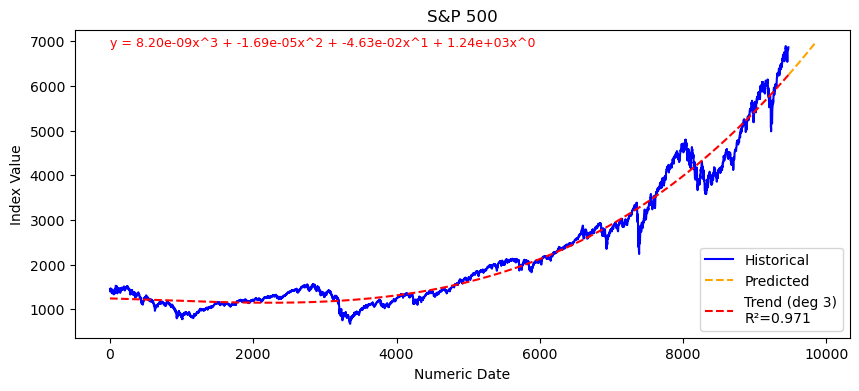

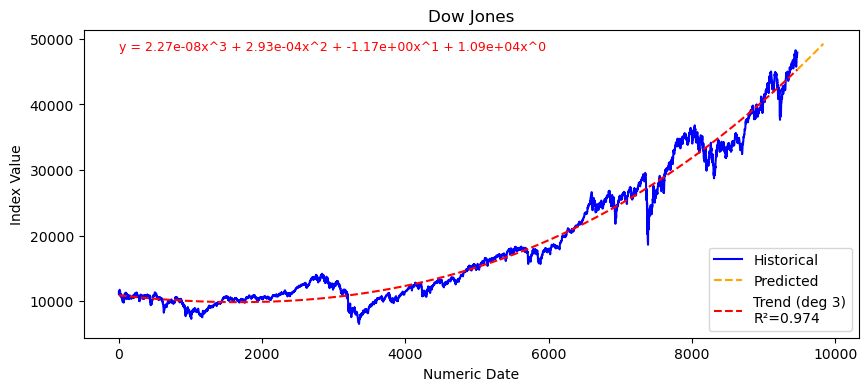

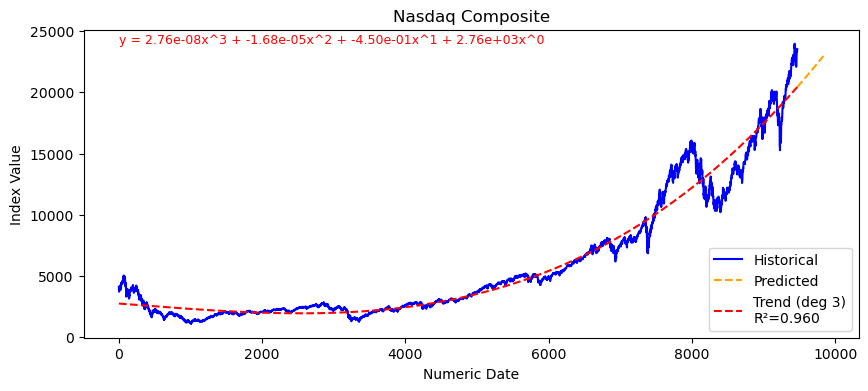

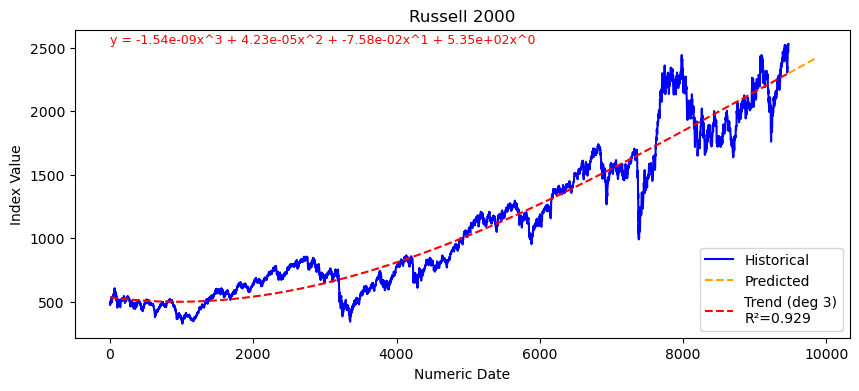

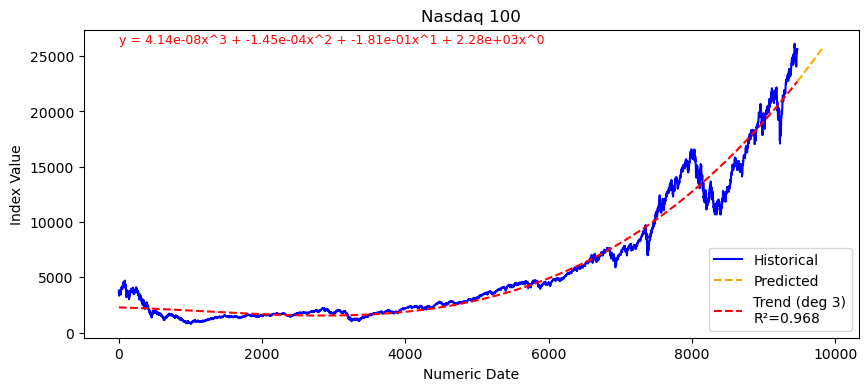

In [9]:
degree = 3

columns = ["S&P 500", "Dow Jones", "Nasdaq Composite", "Russell 2000", "Nasdaq 100"]

for col in columns:
    plt.figure(figsize=(10,4))
    
    # Historical data
    x_hist = df["Numeric Date"]
    y_hist = df[col]
    plt.plot(x_hist, y_hist, label="Historical", color="blue")
    
    # Predicted data
    x_pred = future_df["Numeric Date"]
    y_pred = future_df[col]
    plt.plot(x_pred, y_pred, label="Predicted", color="orange", linestyle='--')
    
    # Polynomial fit
    coeffs = np.polyfit(x_hist, y_hist, degree)
    p = np.poly1d(coeffs)
    y_trend = p(x_hist)
    
    # Calculate R^2
    residuals = y_hist - y_trend
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_hist - np.mean(y_hist))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Plot trendline
    plt.plot(x_hist, y_trend, "r--", label=f"Trend (deg {degree})\nR²={r_squared:.3f}")
    
    # Display equation on plot
    eq_text = "y = " + " + ".join([f"{coeff:.2e}x^{degree-i}" for i, coeff in enumerate(coeffs)])
    plt.text(x_hist.min(), y_hist.max(), eq_text, fontsize=9, color='red')
    
    plt.title(col)
    plt.xlabel("Numeric Date")
    plt.ylabel("Index Value")
    plt.legend()
    plt.show()


The predictions depict a fall of all stocks before a steady increase back up to peak values shown in 2025 for 2026

Heatmap of Correlation

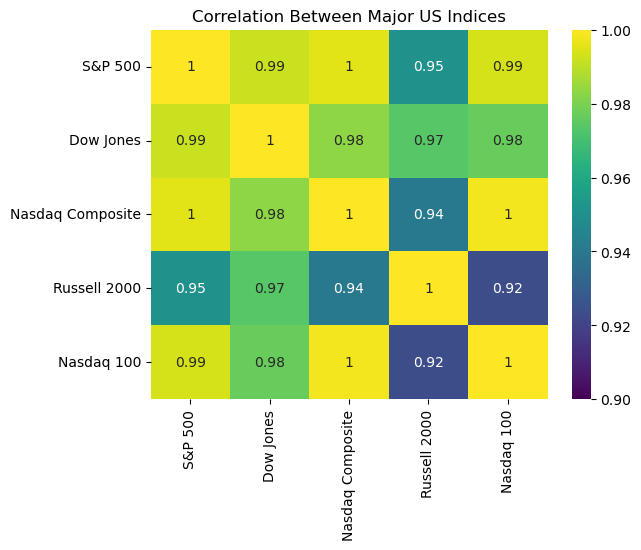

In [10]:
corr = df[["S&P 500","Dow Jones","Nasdaq Composite","Russell 2000","Nasdaq 100"]].corr()
sns.heatmap(corr, annot=True, cmap="viridis", vmin=0.9, vmax=1)
plt.title("Correlation Between Major US Indices")
plt.show()


In [11]:
high_corr = corr[corr > 0.99]
print(high_corr)

                   S&P 500  Dow Jones  Nasdaq Composite  Russell 2000  \
S&P 500           1.000000   0.991998          0.995347           NaN   
Dow Jones         0.991998   1.000000               NaN           NaN   
Nasdaq Composite  0.995347        NaN          1.000000           NaN   
Russell 2000           NaN        NaN               NaN           1.0   
Nasdaq 100        0.993620        NaN          0.998261           NaN   

                  Nasdaq 100  
S&P 500             0.993620  
Dow Jones                NaN  
Nasdaq Composite    0.998261  
Russell 2000             NaN  
Nasdaq 100          1.000000  


This heatmap shows the correlation coefficients between five major U.S. stock indices: S&P 500, Dow Jones, Nasdaq Composite, Russell 2000, and Nasdaq 100. Correlation above 0.99 is also shown in the chart above. What these correlations mean:

S&P 500, Dow Jones, Nasdaq Composite, and Nasdaq 100 all have correlations around 0.98–1.00 with each other.

This means these indices move very closely together, reflecting that they largely track the performance of large-cap U.S. companies.

Russell 2000 correlates with the others around 0.92–0.97.

Russell 2000 tracks smaller-cap companies, which explains the slightly weaker correlation compared to large-cap indices.

The markets are strongly interconnected.

Diversifying only among these indices offers limited risk reduction, since most move together.

Small-cap stocks (Russell 2000) provide slightly different behavior, which could offer a small diversification benefit.